# 準備

## ライブラリの準備

In [1]:
import sys

if 'google.colab' in sys.modules:
    !pip install japanize-matplotlib -qqq

In [2]:
import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sklearn

## 人工データの生成

今回使用する人工データは、サインカーブに正規分布に従う乱数をノイズとして加えて生成した。
シード値は関数内で固定しているのでいつも同じ乱数を返す。

数式で表すと、 $\mathcal{N}(\sin(x), (0.5)^2)$ である。

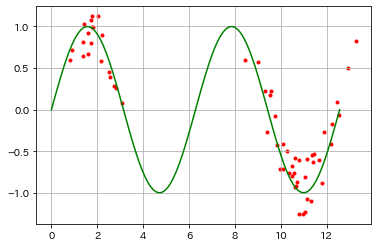

In [3]:
def make_curve():
    np.random.seed(0)

    x = np.hstack([
        np.random.normal(1.5, 0.7, 20), np.random.normal(11, 1, 40)
    ])
    x = np.sort(x)
    y = np.sin(x) + np.random.normal(scale=0.2, size=x.size)

    true_x = np.linspace(0, 4*np.pi, 100)
    return (x, y), (true_x, np.sin(true_x))


sample, true = make_curve()
plt.plot(*true, color="g")
plt.scatter(*sample, marker=".", color="r")
plt.grid(True)

↑真のモデル（緑)と人工データ（赤）の図。

ベイス理論の面白さは、データが密な範囲と疎な範囲でモデルの挙動が変わるところにあるので、人工データもそのようにした。
モデルの学習はまばらに分布する赤点を使って、予測は全区間に対して行う。

In [4]:
def show(x, y, model, test_x, pred):
    fig, (l, r) = plt.subplots(1, 2, figsize=[15, 4])
    
    for ax in [l, r]:
        ax.scatter(x, y, marker=".", color="r")

    ymean, ystd = model.predict(test_x.reshape(-1, 1), return_std=True)
    l.plot(test_x, ymean)
    l.fill_between(test_x, ymean - ystd, ymean + ystd, color="pink", alpha=0.5)
    r.plot(test_x, pred)
    r.fill_between(test_x, pred - ystd, pred + ystd, color="pink", alpha=0.5);
    return l, r

# ベイズ線形回帰

## 理論編

回帰曲線の数式は基底関数による線形回帰とほとんど同じだが、予測結果が値ではなく分布として得られることが特徴。

todo: ベイズの定理

## 実装編

基底関数を適用する処理とモデルをくっつけて [Pipeline][1] を作成した。

いざ実装しようとしたら RBF が2つ提供されていてとまどった。`rbf_kernel` は入力を特徴ベクトルに変換してくれる変換器のようなものだったが、`RBF` はカーネルを作るためのパーツのようだ。カーネルは定義さえ満たせば自作をすることもできるので、`RBF` はそのときに使う関数みたい。
```python
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.gaussian_process.kernels import RBF
```

使っている関数に "カーネル" とい名前がついているが、基底関数として使っていてカーネル関数とは関係ない（多分）。
ここまで実装してきて思ったこと→「sklearn 、`ndarray` の次元に厳しすぎる。」

[1]: https://scikit-learn.org/stable/modules/compose.html

In [5]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.linear_model import BayesianRidge
from sklearn.metrics.pairwise import rbf_kernel as rbf
from sklearn.pipeline import Pipeline


class RBFTransfomer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.loc = np.arange(15).reshape(-1, 1)

    def fit(self, X, y):
        return self

    def transform(self, X):
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        return rbf(X, self.loc)

    def __repr__(self):
        return self.__class__.__name__ + "()"


rbfbayes = Pipeline([("rbf", RBFTransfomer()), ("bayes", BayesianRidge(lambda_2=10))])

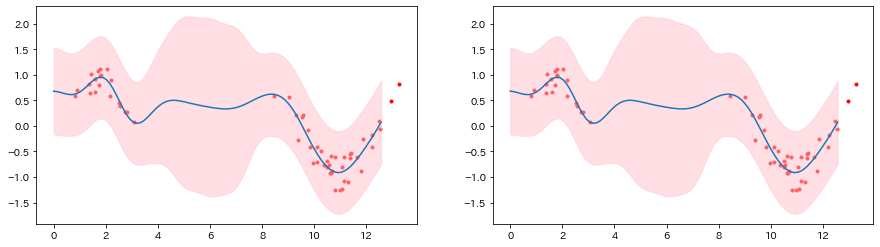

In [6]:
(x, y), (test_x, _) = make_curve()
rbfbayes.fit(x, y)

K = rbfbayes["rbf"].transform(test_x)
pred = rbfbayes["bayes"].coef_ @ K.T + rbfbayes["bayes"].intercept_

show(x, y, rbfbayes, test_x, pred);

## 感想編

データが密な範囲では、真のモデルと回帰曲線（青線）がよく似ているが、疎な範囲は回帰できているとは言えない。
通常の線形回帰モデルから得られる情報はここで終わりだが、ベイズ理論はここでは終わらない。

ベイズ理論を用いたモデルは、予測した点の自信を赤い領域の幅で表現することができる。傾向として、データが密な範囲はうまく予測できて、疎な範囲はできない。それがしっかりと赤い領域の幅にも現れている。

結果の信頼性という観点から、ビジネス的にはこちらのモデルの方が好まれることもある。

<br>

ただ、2次元の図を使うと本当は分布の断面ということが伝わらないことが多い印象がある。というわけで実際に3次元グラフを作ってみた。
こうすると、自身の強さは赤い領域の狭さではなく山の高さという直感的な表現になる。

上図の青線は、この山脈の頂上の尾根線（最頻値）である。確率モデルを使っているのに回帰曲線だけしか使わないのは、頂上以外の分布の形状の情報を捨てていることになるのでとてももったいない。

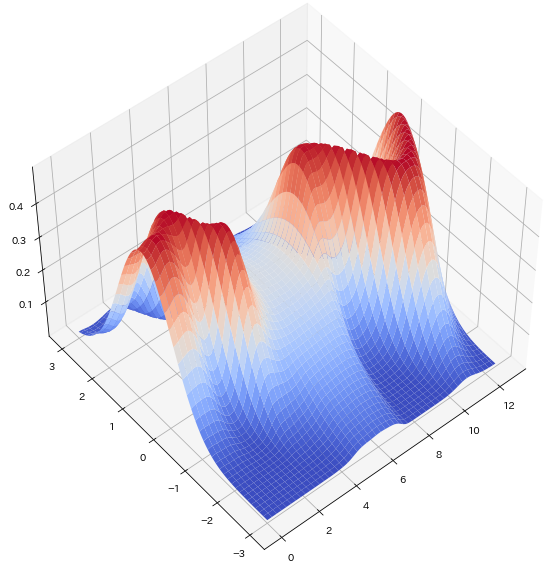

In [7]:
from scipy.stats import norm

ymean, ystd = rbfbayes.predict(test_x, return_std=True)

XX, YY = np.meshgrid(test_x, np.linspace(-3, 3, 100))
Z = norm.pdf(x=np.linspace(-3, 3, 100).reshape(-1, 1), loc=ymean, scale=ystd)
fig, ax = plt.subplots(subplot_kw={"projection": '3d'}, figsize=[10, 10])
ax.plot_surface(XX, YY, Z, linewidth=0, cmap="coolwarm")
ax.view_init(elev=50, azim=230)

# ガウス過程

## 理論編

先程のモデルは RBF を等間隔に15個用意して、それらの強弱をいい塩梅にして回帰していた。
つまり、「真のモデルはRBFを15くらい用意すればうまく回帰できるだろう」という前提が裏にあるとも言える。
しかし、本来回帰をする目的は説明変数と目的変数がどんな関係になるかを知りたいからなので、この前提には天下り的な印象がある。

ガウス過程というアルゴリズムを使えば、モデルに置かれる前提を減らすことができるため、どんな形状のデータでもある程度対応できるようになる。
ただしその分、計算量は増えてしまう。
これは多項式回帰と同じ結果をカーネル法でも得られる流れと同じである。

## 実装編

モデルの前提がなくなりデータをただ渡すだけになったので、その分実装もシンプルになっている。

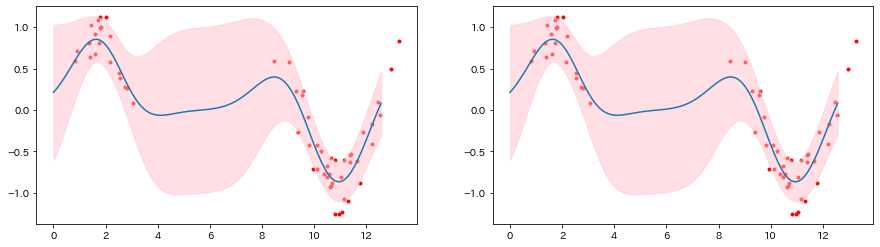

In [8]:
from sklearn.gaussian_process import GaussianProcessRegressor

(x, y), (test_x, _) = make_curve()

gp = GaussianProcessRegressor(alpha=1)
gp.fit(x.reshape(-1, 1), y.ravel())

K = gp.kernel_(test_x.reshape(-1, 1), gp.X_train_)
pred = K @ gp.alpha_

show(x, y, gp, test_x, pred);

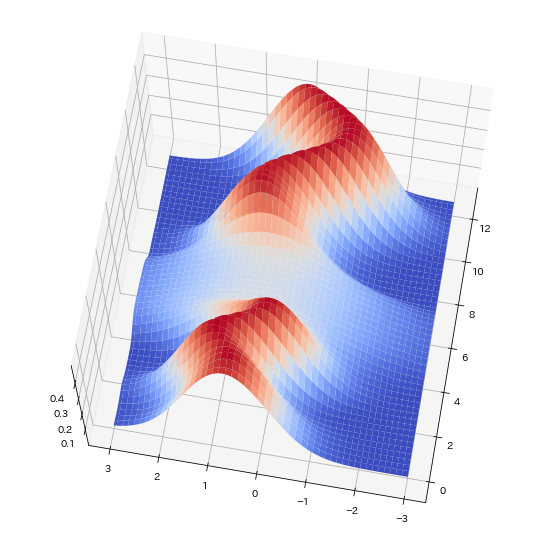

In [9]:
from scipy.stats import norm

XX, YY = np.meshgrid(test_x, np.linspace(-3, 3, 100))
Z = norm.pdf(x=np.linspace(-3, 3, 100).reshape(-1, 1), loc=ymean, scale=ystd)

fig, ax = plt.subplots(subplot_kw={"projection": '3d'}, figsize=[10, 10])
ax.plot_surface(XX, YY, Z, linewidth=0, cmap="coolwarm")
ax.view_init(elev=70, azim=190)

## 感想編

- モデルの前提が不要
- モデルの予測に添えて自信も得ることができる

もう最強のように聞こえるが、計算量がデータの3乗のオーダになってしまうというデメリットが実用に置いては致命的。このモデルはデータが少なくてモデルの予測を信用できないときに使うのが正しい使い方なのかな。